## Исследование результатом AB тестирования

План исследования:

Логический анализ данных

Распределение данных

In [1]:
# импортировать необходимые библиотеки
import pandas as pd
import numpy as np


In [2]:
# Чтение данных с указанием типов данных
df = pd.read_excel('AB_Test.xlsx', dtype={'REVENUE': float})
df.head(10)

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [3]:
# посмотрим датасет
df.describe()


,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


## Что могу сказать из предварительных данных?

* датасет состоит из 10000 строк, это большое количество данных, значит быдем использовать z критерий для проверки статистической значимости различий между контрольной и тестовой группой
* На основе предоставленного описания датасета по столбцу "REVENUE", можно сделать следующие умозаключения:

#### Среднее значение (mean):

Среднее значение REVENUE равно 0.099447, что гораздо меньше максимального значения REVENUE (196.0100000). Это может указывать на то, что большинство значений REVENUE находится близко к нулю.

#### Стандартное отклонение (std):

Стандартное отклонение REVENUE равно 2.318529. Это означает, что значения REVENUE имеют значительный разброс относительно среднего значения. Высокое стандартное отклонение может указывать на наличие выбросов в данных.

#### Минимальное и максимальное значения (min, max):

Минимальное значение REVENUE равно 0.000000, а максимальное значение равно 196.010000. Поскольку 75% значений находятся в диапазоне до 0.000000, значение 196.010000 является максимальным, возможно, выбросом, который может потребовать дополнительного внимания при анализе.

#### Квартили (25%, 50%, 75%):

25% значений REVENUE равны 0.000000, что подтверждает предположение о том, что большинство значений близко к нулю.
50% (медиана) также равны 0.000000.
75% значений REVENUE также равны 0.000000, что дополнительно подтверждает, что большинство значений находятся в нижнем диапазоне.

На основе этих умозаключений можно предположить, что большинство данных в столбце REVENUE равны нулю или близки к нулю, с небольшим количеством значений, возможно, являющихся выбросами. 
При дальнейшем анализе данных, особенно при рассмотрении выбросов, стоит учитывать особенности распределения и структуры данных в этом столбце.
Соответственно, если в будущем мы выясним что при тестировании один из вариантов заработал больше прибыли, это может быть случайным результатом, так как какой то ай ди просто совершил 1 покупку, которая принеслап статистически значимое рахзличие 

In [4]:
# для общей справки посмотрим, а все ли сай ди уникальны, так как один или два колиента могут купить на большую сумму, что нивелирует по моему мнению результат тестирования
# Подсчет количества уникальных USER_ID
unique_user_ids = df['USER_ID'].nunique()

# Вывод на печать количества уникальных USER_ID
print(f"Количество уникальных USER_ID: {unique_user_ids}")

Количество уникальных USER_ID: 6324


Посмотримм нет ли одного и того же человека в двух группах

In [5]:
# Поиск строк с одинаковыми USER_ID, но разными VARIANT_NAME
duplicates_with_different_variant = df[df.duplicated(subset='USER_ID', keep=False) & 
                                       df.groupby('USER_ID')['VARIANT_NAME'].transform('nunique').gt(1)]

# Вывод результата
duplicates_with_different_variant.sort_values(by='USER_ID').head()

,USER_ID,VARIANT_NAME,REVENUE
7409,3,variant,0.0
5377,3,control,0.0
4145,3,variant,0.0
4612,10,variant,0.0
5545,10,control,0.0


In [6]:
dublicated_id = sorted(duplicates_with_different_variant ['USER_ID'].unique())
len(dublicated_id)

1541

итак. у нас 3930 строк, которые могут исказить данные. 1541 айдишник содержит противоречивые данные. 

это может быть по нескольким причинам, по какой точно мы не знаем:
1. ошибки в ай ди. разные пользователи по какой то причине получили один и тот же ай ди или тот кто вносил данные внес ай ди не верно
2. при разных заходах пользователь попадал на разные версии сайта...была ошибка разделения  на выборки

мы можем поступить следующим образом:
1. удалить все ай ди (так как мы не знаем к какой точно группе принадлежат пользователи)
2. удалить все ай ди, в которых нет показателя прибыли... но это исказит данные
3. проигнорировать ошибку ( не учитывать ай ди)

вообще стоило бы настучать по рукам тем кто делал разделение, так как юзер попадая на рызные версии сайта, может посчитать себя идиотом, тем не менее...по нашим данным, он может принести прибыль на новой версии сайта, и оставаться безучастным на старой+)).

посмотрим на данные. 
Мы видим, что есть выброс, удалим его

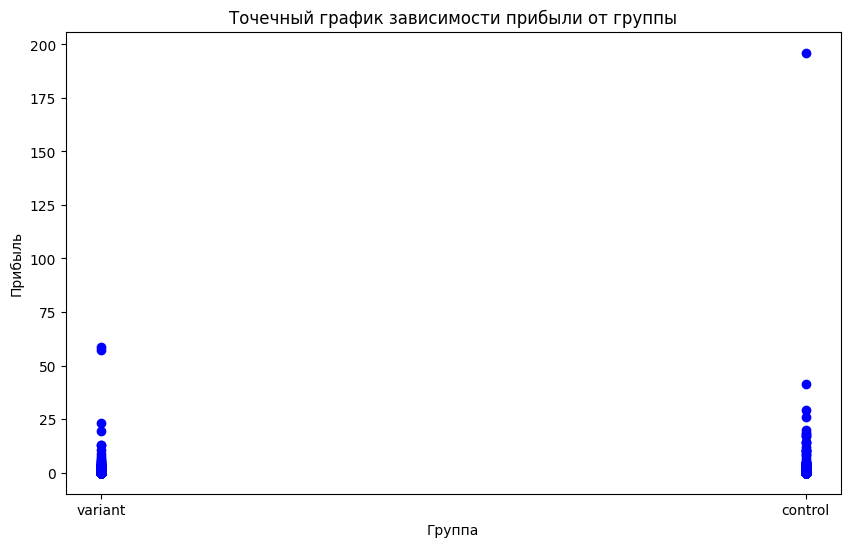

In [19]:
import matplotlib.pyplot as plt
# Создание точечного графика
plt.figure(figsize=(10, 6))
plt.scatter(df['VARIANT_NAME'], df['REVENUE'], color='blue')  # Замените цвет по своему усмотрению
plt.xlabel('Группа')
plt.ylabel('Прибыль')
plt.title('Точечный график зависимости прибыли от группы')
plt.show()

Удалим. Почему? потому что, если бы это была систематическая покупка на большю сумму, только если кнопка будет красной, то это было бы важно, а так, это просто может быть случайностью.
1. продолжаем тестировать
2. не расчитавыем на эту покупку и смотрим что то более реальное

В тестовой группе так же есть не типичные покупки, но они не так сильно отдалены от всех данных


In [21]:
cleaned_df = df[df['REVENUE'] < 196]
cleaned_df.describe()

,USER_ID,REVENUE
count,9999.000000,9999.000000
mean,4981.244124,0.079854
std,2890.688186,1.239704
min,2.000000,0.000000
25%,2468.500000,0.000000
50%,4962.000000,0.000000
75%,7512.000000,0.000000
max,10000.000000,58.630000


Разделим датасеты:


In [22]:
control_group =  cleaned_df[cleaned_df['VARIANT_NAME'] == 'control']

test_group = cleaned_df[cleaned_df['VARIANT_NAME'] == 'variant']

## Теперь нам нужно:
* количество пользователей в 2 группах
* прибыль в 2 группах
* провести тест на распределение для выбора метода статистического анализа
* выявить статистические различия между группами
* принять или опровергнуть нулевую гипотезу

1. сгруппируем по ай ди. просуммируем прибыль по каждому ай ди

In [23]:
test_group= test_group.groupby('USER_ID')['REVENUE'].sum().reset_index()
test_group

,USER_ID,REVENUE
0,3,0.00
1,4,0.00
2,5,0.00
3,6,0.00
4,9,0.00
...,...,...
3929,9986,0.00
3930,9990,0.00
3931,9995,0.00
3932,9996,6.46


In [24]:
# Группировка по USER_ID и суммирование REVENUE
control_group = control_group.groupby('USER_ID')['REVENUE'].sum().reset_index()

# Вывод результата
control_group

,USER_ID,REVENUE
0,2,0.0
1,3,0.0
2,10,0.0
3,11,0.0
4,12,0.0
...,...,...
3925,9992,0.0
3926,9993,0.0
3927,9996,0.0
3928,9998,0.0


Получим количество ай ди в каждой группе

In [25]:
control_count = control_group['USER_ID'].count()
test_count =  test_group['USER_ID'].count()

Получим прибыль по каждой группе

In [26]:
control_count = control_group['USER_ID'].count()
test_count =  test_group['USER_ID'].count()
rev_sum_control = control_group['REVENUE'].sum()
rev_sum_test =  test_group['REVENUE'].sum()

In [27]:
rev_sum_control

446.99

In [28]:
rev_sum_test

351.46999999999997

 Проведем тест на нормальность распределения
 
 Формально это выглядит так:

Если p-value < a, то отвергнуть нулевую гипотезу.
Если p-value >= a, то нет оснований отвергнуть нулевую гипотезу.

In [31]:
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

alpha = 0.05

# Тест Шапиро-Уилка для контрольной группы
statistic_control, p_value_control = shapiro(control_group['REVENUE'])
print(f"Тест Шапиро-Уилка для контрольной группы:")
print(f"Статистика теста: {statistic_control}")
print(f"P-значение: {p_value_control}")
if p_value_control > alpha:
    print("Распределение в контрольной группе схоже с нормальным.")
else:
    print("Есть основания отвергнуть гипотезу о нормальности распределения в контрольной группе.")

# Тест Шапиро-Уилка для тестовой группы
statistic_test, p_value_test = shapiro(test_group['REVENUE'])
print("\nТест Шапиро-Уилка для тестовой группы:")
print(f"Статистика теста: {statistic_test}")
print(f"P-значение: {p_value_test}")
if p_value_test > alpha:
    print("Распределение в тестовой группе схоже с нормальным.")
else:
    print("Есть основания отвергнуть гипотезу о нормальности распределения в тестовой группе.")

# Если распределение схоже с нормальным, применяем t-тест
if p_value_control > alpha and p_value_test > alpha:
    # Проведение t-теста
    t_stat, p_value_ttest = ttest_ind(control_group['REVENUE'], test_group['REVENUE'], equal_var=False)

    # Вывод результатов теста
    print(f"\nT-статистика: {t_stat}")
    print(f"P-значение (t-тест): {p_value_ttest}")

    # Проверка статистической значимости
    if p_value_ttest < alpha:
        print("Есть статистически значимые различия между группами (t-тест).")
    else:
        print("Статистически значимых различий между группами не обнаружено (t-тест).")
# Иначе применяем непараметрический тест Уилкоксона-Манна-Уитни
else:
    # Проведение теста Уилкоксона-Манна-Уитни
    statistic, p_value_mannwhitneyu = mannwhitneyu(control_group['REVENUE'], test_group['REVENUE'])

    # Вывод результатов теста
    print(f"\nСтатистика U (тест Уилкоксона-Манна-Уитни): {statistic}")
    print(f"P-значение (тест Уилкоксона-Манна-Уитни): {p_value_mannwhitneyu}")

    # Проверка статистической значимости
    if p_value_mannwhitneyu < alpha:
        print("Есть статистически значимые различия между группами (тест Уилкоксона-Манна-Уитни).")
    else:
        print("Статистически значимых различий между группами не обнаружено (тест Уилкоксона-Манна-Уитни).")


Тест Шапиро-Уилка для контрольной группы:
Статистика теста: 0.06129390001296997
P-значение: 0.0
Есть основания отвергнуть гипотезу о нормальности распределения в контрольной группе.

Тест Шапиро-Уилка для тестовой группы:
Статистика теста: 0.03283834457397461
P-значение: 0.0
Есть основания отвергнуть гипотезу о нормальности распределения в тестовой группе.

Статистика U (тест Уилкоксона-Манна-Уитни): 7746585.5
P-значение (тест Уилкоксона-Манна-Уитни): 0.4950055422278089
Статистически значимых различий между группами не обнаружено (тест Уилкоксона-Манна-Уитни).


Рекомендация - не вносить изменения, или определить дополнительные метрикиЖ. которые могут повлиять на прибыль, средний чек, увеличение числа платящих пользователей и тому подобное. 